# Mid-term AI Project - AIDE300

**- Lâm Tiểu My - 2112253048 - AIDE300**

# About the project

This project investigates two approaches to predicting earthquake rupture behavior: **Random Forest Classifiers (RFC)** and **Neural Networks (NNs)**. The project leverages geophysical data, including stress tensors, friction coefficients, and displacements, to classify rupture outcomes (arrest or propagation). Using feature engineering (e.g., creating the 'sfactor'), both models are trained and evaluated with metrics such as accuracy, F1-score, and AUC-ROC. By comparing RFC and NNs, the project provides insights into the strengths of different machine learning techniques for seismic prediction.

# Random Forest Classification

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

random_state = 10
np.random.seed(random_state)

## Import data

In [3]:
df = pd.read_csv(r"C:\Users\Lenovo\OneDrive - ftu.edu.vn\Desktop\Github\AI-assignment-prj\heart.csv")

In [8]:
train_file = r"data\rupturemodel_train.txt"
val_file = r"data\rupturemodel_validate.txt"
test_file = r"data\rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

columns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = columns
df_val.columns = columns
df_test.columns = columns

frames = [df_train, df_val]
df_train = pd.concat(frames)
print('train data shape {} and test data shape {}'.format(np.shape(df_train), np.shape(df_test)))

train data shape (1600, 9) and test data shape (400, 9)


In [10]:
df_train.head()

,height,width,sxx,sxy,syy,sdrop,mud,dc,label
0,0.103861,1.145663,-102.509086,58.619371,-117.766562,0.483821,0.216681,0.295842,0.0
1,0.088714,1.304360,-136.062270,51.391037,-126.715571,0.345944,0.447964,0.406466,1.0
2,0.099706,1.260377,-117.558936,40.972081,-115.529343,0.292719,0.501697,0.389360,1.0
3,0.115749,1.191782,-128.169036,94.020712,-157.830504,0.571710,0.202831,0.408976,0.0
4,0.017900,1.108150,-106.350320,29.148969,-101.379323,0.253122,0.324653,0.398592,1.0


The variables in this dataset describe various aspects of seismic activity, which are used to predict earthquake rupture.

| Variable | Description |
|----------|-------------|
| **height** | Represents the vertical displacement or slip height in an earthquake. |
| **width**  | Likely indicates the rupture width, or the horizontal dimension of the fault. |
| **sxx**    | Stress component in the x-direction, part of the stress tensor in seismology. |
| **sxy**    | Shear stress component, representing the stress acting parallel to the fault. |
| **syy**    | Stress component in the y-direction, also part of the stress tensor. |
| **sdrop**  | The stress drop, indicating the reduction in stress during an earthquake. |
| **mud**    | Could represent frictional strength or a similar measure related to the fault. |
| **dc**     | Slip or displacement in meters, indicating how much the fault has moved. |
| **label**  | The target variable, indicating whether a rupture occurred (e.g., 0 for no rupture, 1 for rupture). |

## Data Preparation

### Features Standardization

We standardize features to ensure that each variable contributes equally to the distance calculations in algorithms that rely on distance metrics, such as k-nearest neighbors and support vector machines. Standardization transforms the data to have a mean of zero and a standard deviation of one, which helps to mitigate the effects of different scales among features. This is particularly important when features have varying units or ranges, as unstandardized features can lead to biased results, where certain variables dominate the learning process. Additionally, standardization can accelerate convergence during the training of models, especially those that use gradient-based optimization methods, by ensuring that the gradients are of a similar scale

In [11]:
mms = StandardScaler()
xtrain = mms.fit_transform(df_train.drop('label', axis=1))
ytrain = df_train['label'].values
xtest = mms.fit_transform(df_test.drop('label', axis=1))
ytest = df_test['label'].values

In [12]:
df_train.head()

,height,width,sxx,sxy,syy,sdrop,mud,dc,label
0,0.103861,1.145663,-102.509086,58.619371,-117.766562,0.483821,0.216681,0.295842,0.0
1,0.088714,1.304360,-136.062270,51.391037,-126.715571,0.345944,0.447964,0.406466,1.0
2,0.099706,1.260377,-117.558936,40.972081,-115.529343,0.292719,0.501697,0.389360,1.0
3,0.115749,1.191782,-128.169036,94.020712,-157.830504,0.571710,0.202831,0.408976,0.0
4,0.017900,1.108150,-106.350320,29.148969,-101.379323,0.253122,0.324653,0.398592,1.0


### Feature Transposition and Target Extraction

In [14]:
xtransfer = np.transpose(np.array(df_train.drop('label', axis=1)))
ytransfer = list(df_train.label.values)

In [15]:
xtransfer

array([[ 1.03861000e-01,  8.87140000e-02,  9.97060000e-02, ...,
         2.45450000e-02,  1.35133000e-01,  9.90780000e-02],
       [ 1.14566300e+00,  1.30436000e+00,  1.26037700e+00, ...,
         2.00795800e+00,  1.88491900e+00,  1.83929100e+00],
       [-1.02509086e+02, -1.36062270e+02, -1.17558936e+02, ...,
        -7.07691400e+01, -2.12003590e+01, -7.98741440e+01],
       ...,
       [ 4.83821000e-01,  3.45944000e-01,  2.92719000e-01, ...,
         2.72537000e-01,  3.48628000e-01,  2.93341000e-01],
       [ 2.16681000e-01,  4.47964000e-01,  5.01697000e-01, ...,
         4.33502000e-01,  3.08436000e-01,  3.08371000e-01],
       [ 2.95842000e-01,  4.06466000e-01,  3.89360000e-01, ...,
         3.91503000e-01,  3.83268000e-01,  3.63256000e-01]])

## Exploratory Data Analysis

### Correlation Analysis

<Axes: >

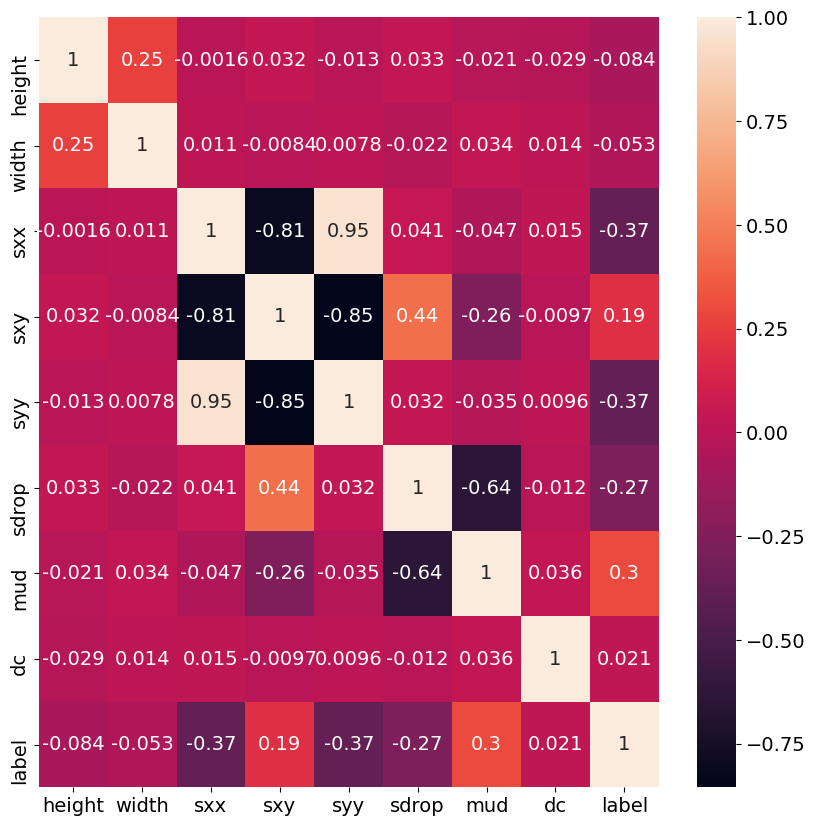

In [21]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
sns.heatmap(df_train.corr(), annot = True)

- **sxx and syy**: Strong positive correlation of **0.95**, indicating that these stress components behave similarly.
  
- **sxy**: Strong negative correlation with **sxx (-0.81)** and **syy (-0.85)**, suggesting that this stress component behaves oppositely to the others.
  
- **mud**: Moderate positive correlation with the **label (0.3)**, indicating it might be an important predictor for rupture.

### Class Imbalance 

In [22]:
label_count = df_train.groupby('label', as_index = False).count()
class_name = ['Rupture arrest', 'Rupture propagate']
count = list(label_count['height'])
print('Rupture propagate : {}, \nRupture arrest: {}'.format(count[0], count[1]))
print('Total number of data: {}'.format(np.sum(count)))
print('Class ratio for rupture propagation: {}'.format(count[0]/count[1]))

Rupture propagate : 1041, 
Rupture arrest: 559
Total number of data: 1600
Class ratio for rupture propagation: 1.8622540250447228


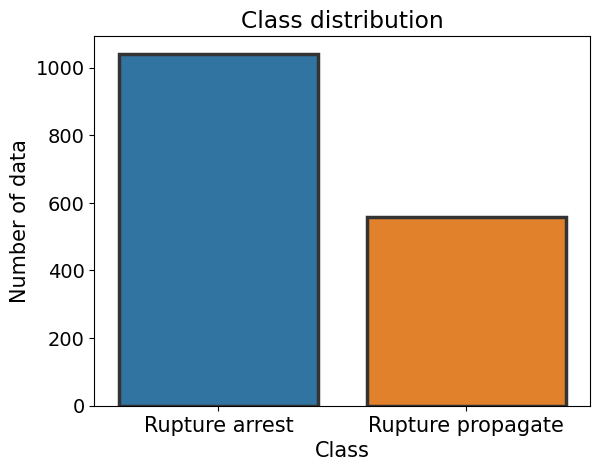

In [23]:
index = np.arange(len(class_name))
sns.barplot(x = class_name, y = count, linewidth = 2.5, errcolor = ".2", edgecolor = ".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

- We don't need to resample the data in this case because, while there is an imbalance between the two classes ("Rupture arrest" and "Rupture propagate"), the imbalance is not extremely severe. The minority class still has a significant number of samples, allowing the model to learn from both classes. 

- Additionally, techniques such as adjusting class weights during model training or using algorithms robust to class imbalance (e.g., Random Forest or XGBoost) can handle this level of imbalance without the need for resampling.

In [25]:
POS_CLASS_RATIO = count[0]/count[1]
aa = class_weight.compute_class_weight(class_weight='balanced', 
                                       classes=np.unique(ytrain.astype(int)), 
                                       y=ytrain.astype(int))
CLASS_WEIGHT = {0 : aa[0] , 1: aa[1]}

In [26]:
CLASS_WEIGHT

{0: 0.7684918347742555, 1: 1.4311270125223614}

### Train and Hyperparameters Tuning for RFC model

In [27]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 40, 70)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion='entropy',
        random_state=random_state,
        class_weight='balanced'
    )

    return cross_val_score(clf, xtrain, ytrain.astype(int), cv=cv, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params


[I 2024-09-21 21:17:05,992] A new study created in memory with name: no-name-292c27fd-2228-4c7d-a81e-8d0d8f409da2
[I 2024-09-21 21:17:06,163] Trial 0 finished with value: 0.72375 and parameters: {'n_estimators': 13, 'max_depth': 3, 'min_samples_split': 63}. Best is trial 0 with value: 0.72375.
[I 2024-09-21 21:17:06,585] Trial 1 finished with value: 0.736875 and parameters: {'n_estimators': 25, 'max_depth': 9, 'min_samples_split': 60}. Best is trial 1 with value: 0.736875.
[I 2024-09-21 21:17:08,116] Trial 2 finished with value: 0.7406250000000001 and parameters: {'n_estimators': 90, 'max_depth': 9, 'min_samples_split': 66}. Best is trial 2 with value: 0.7406250000000001.
[I 2024-09-21 21:17:09,382] Trial 3 finished with value: 0.7350000000000001 and parameters: {'n_estimators': 74, 'max_depth': 9, 'min_samples_split': 56}. Best is trial 2 with value: 0.7406250000000001.
[I 2024-09-21 21:17:10,383] Trial 4 finished with value: 0.73875 and parameters: {'n_estimators': 61, 'max_depth': 8

In [28]:
print('\n # Best parameters ---------\n{}'.format(study.best_params))

print('\n # Best score ---------\n{}'.format(study.best_value))

best_model = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    criterion='entropy',
    random_state=random_state,
    class_weight='balanced'
)

best_model.fit(xtrain, ytrain.astype(int))

print('\n # Best model created with optimal parameters.')



 # Best parameters ---------
{'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 47}

 # Best score ---------
0.7481249999999999

 # Best model created with optimal parameters.


### Prediction on Test set

In [29]:
ypred = best_model.predict(xtest)

In [30]:
print('The accuracy of the model is {}'.format(accuracy_score(ytest, ypred)))
print('# Classification report \n {}'.format(classification_report(ytest, ypred)))

The accuracy of the model is 0.81
# Classification report 
               precision    recall  f1-score   support

         0.0       0.90      0.81      0.85       272
         1.0       0.67      0.80      0.73       128

    accuracy                           0.81       400
   macro avg       0.78      0.81      0.79       400
weighted avg       0.82      0.81      0.81       400



The classification report for the Random Forest classifier shows an overall accuracy of **81%**, indicating good performance. 

- **Class 0.0 (Rupture arrest)**:
  - Precision: **0.90**
  - Recall: **0.81**
  - F1-score: **0.85**

  This suggests that the model performs very well in identifying instances of this class.

- **Class 1.0 (Rupture propagate)**:
  - Precision: **0.67**
  - Recall: **0.80**
  - F1-score: **0.73**

  This indicates slightly weaker performance but is still acceptable.

The macro average F1-score is **0.79**, showing balanced performance across both classes.

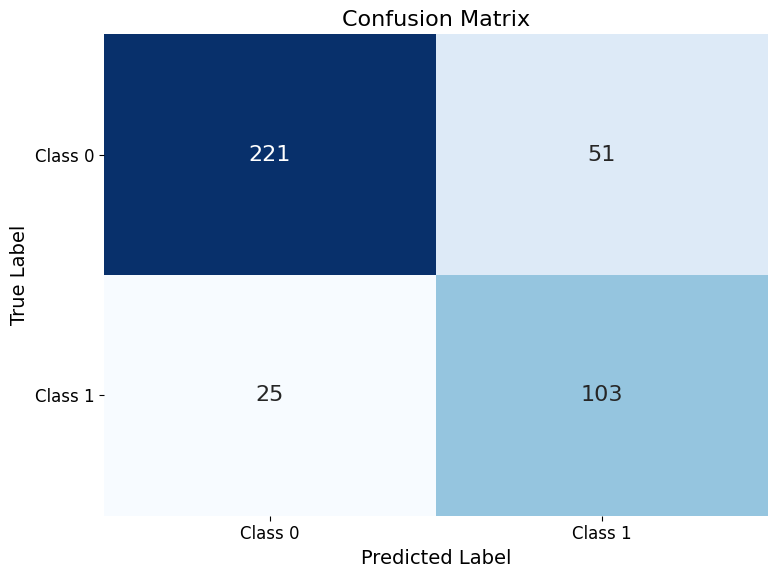

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, ypred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

For **Class 0 (Rupture arrest)**:
- **Correctly Predicted**: 221 instances
- **Misclassified as Class 1 (Rupture propagate)**: 51 instances

For **Class 1 (Rupture propagate)**:
- **Correctly Predicted**: 103 instances
- **Misclassified as Class 0 (Rupture arrest)**: 25 instances

The matrix shows that the model performs well on **Class 0**, with fewer errors compared to **Class 1**.

Feature ranking:
1. Feature mud (18.17%)
2. Feature sxx (17.4%)
3. Feature syy (16.79%)
4. Feature sdrop (15.64%)
5. Feature sxy (14.36%)
6. Feature height (7.13%)
7. Feature width (5.54%)
8. Feature dc (4.96%)


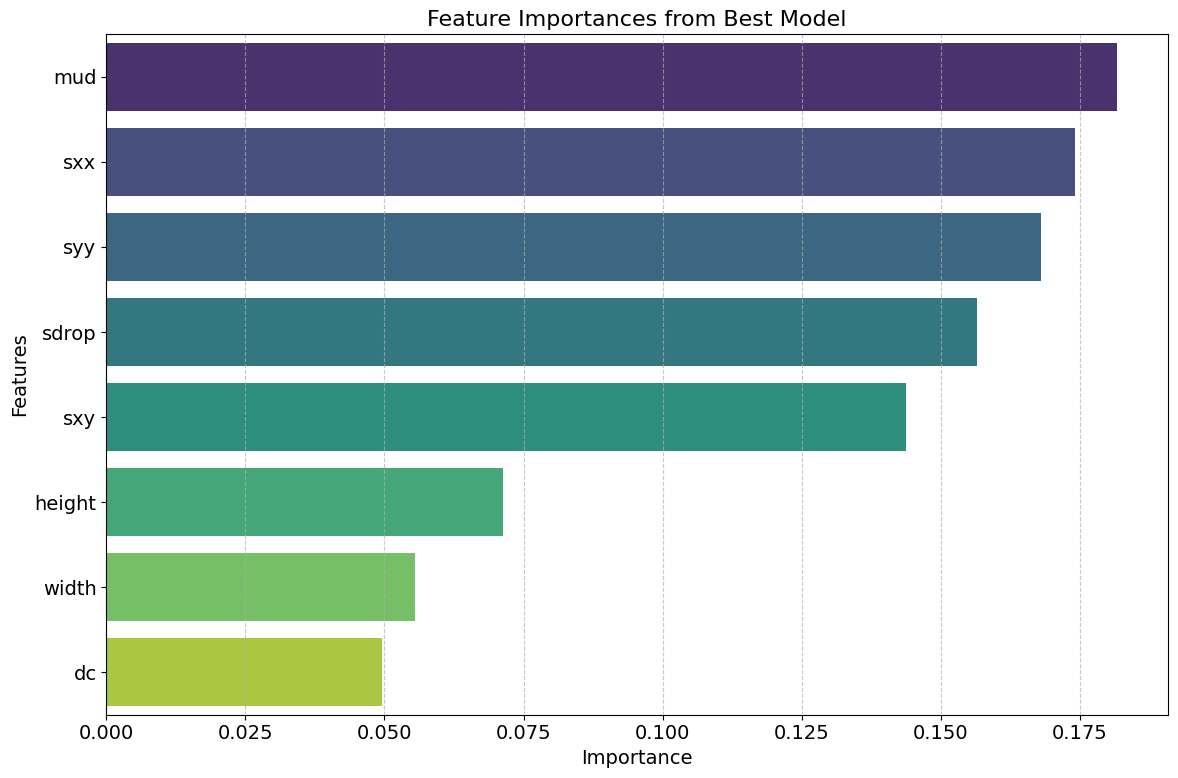

In [33]:
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

length = len(list(df_train))
features = list(df_train)[:length-1]

print("Feature ranking:")

features_rank = []
label_name = []
for f in range(xtrain.shape[1]):
    features_rank.append(importances[indices[f]])
    label_name.append(features[indices[f]])
    print("{}. Feature {} ({}%)".format(f + 1, features[indices[f]], round(importances[indices[f]] * 100, 2)))

plt.figure(figsize=(12, 8))
sns.barplot(x=features_rank, y=label_name, palette='viridis')
plt.title("Feature Importances from Best Model", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- **Most Important Variables**:
  - **mud**: The most significant factor in predicting earthquake rupture.
  - **sxx** and **syy**: Key components of the stress tensor that also play a critical role in the model's predictions.

- **Moderately Important Variables**:
  - **sdrop**: Represents stress drop.
  - **sxy**: Another component of stress.
  - **height**: Contributes to the predictions but to a lesser extent.

- **Less Important Variables**:
  - **width** and **dc (displacement)**: These features have comparatively lower importance, indicating they have a smaller influence on the model's performance.

In [41]:
shap.initjs()
ix = 5

print('Actual value: {}, Prediction: {}, Probability: {}'.
      format(int(ytest[ix]), 
             best_model.predict(np.reshape(xtest[ix], (1, -1)))[0],
             best_model.predict_proba(np.reshape(xtest[ix], (1, -1)))[0]))

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(xtest)
shap.force_plot(explainer.expected_value[0],shap_values[0][ix], 
                features = columns[0:8])

Actual value: 0, Prediction: 0, Probability: [0.60561681 0.39438319]


Our plot explains the model's prediction for an individual instance (index 5) as follows:

- **Actual Value**: 0 (Rupture arrest)
- **Predicted Value**: 0
- **Probability**:
  - Class 0 (Rupture arrest): **60.6%**
  - Class 1 (Rupture propagate): **39.4%**

#### Contributing Features
- **Positive Contributors** (pushing the prediction toward Class 0):
  - **dc**
  - **height**
  - **mud**
  - **sdrop**

- **Negative Contributors** (pushing the prediction toward Class 1):
  - **syy**
  - **sxy**

Despite the contributions from syy and sxy toward Class 1, their influence was outweighed by the positive factors listed above.

In [42]:
print(xtest[ix])
explainer = lime_tabular.LimeTabularExplainer(np.array(xtrain), mode = 'classification', feature_names = columns, training_labels = ytrain)
exp = explainer.explain_instance(np.array(xtest)[ix,:], best_model.predict_proba, num_features = 8, top_labels = None)
exp.show_in_notebook(show_table = True, show_all = True)

[ 0.46029961  0.1061683  -0.31380644  1.3404829  -0.816337    1.15223258
 -0.52257067  0.07505862]


We observe the feature contributions for an individual instance. The predicted probability for ***Class 0 (Rupture arrest)*** is 61%, while ***Class 1 (Rupture propagate)*** has a 39% probability. Features such as sdrop, mud, and height strongly influence the prediction toward Class 0, as their values push the model's prediction in that direction. Conversely, features like sxx, sxy, and syy push the prediction toward Class 1, but their influence is outweighed by the other features

# Neural Networks Approach

In [64]:
import warnings
warnings.filterwarnings("ignore") 

from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd

random_seed = 100
np.random.seed(random_seed)

## Data Preparation

In [70]:
train_file = r"data\rupturemodel_train.txt"
val_file = r"data\rupturemodel_validate.txt"
test_file = r"data\rupturemodel_test.txt"

df_train = pd.read_csv(train_file, sep=" ", header=None)
df_val = pd.read_csv(val_file, sep=" ", header=None)
df_test = pd.read_csv(test_file, sep=" ", header=None)

features_name = ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = pd.concat([df_train, df_val], ignore_index=True)
df_train_all['mus'] = df_train_all.sdrop + df_train_all.mud
df_train_all

,height,width,sxx,sxy,syy,sdrop,mud,dc,label,mus
0,0.103861,1.145663,-102.509086,58.619371,-117.766562,0.483821,0.216681,0.295842,0.0,0.700502
1,0.088714,1.304360,-136.062270,51.391037,-126.715571,0.345944,0.447964,0.406466,1.0,0.793908
2,0.099706,1.260377,-117.558936,40.972081,-115.529343,0.292719,0.501697,0.389360,1.0,0.794416
3,0.115749,1.191782,-128.169036,94.020712,-157.830504,0.571710,0.202831,0.408976,0.0,0.774541
4,0.017900,1.108150,-106.350320,29.148969,-101.379323,0.253122,0.324653,0.398592,1.0,0.577775
...,...,...,...,...,...,...,...,...,...,...
1595,0.037627,1.255533,-114.985388,26.099411,-102.644432,0.217412,0.404463,0.347479,1.0,0.621875
1596,0.025419,1.196725,-152.090422,92.099420,-158.179886,0.574279,0.222848,0.383544,0.0,0.797127
1597,0.024545,2.007958,-70.769140,21.592787,-65.544682,0.272537,0.433502,0.391503,1.0,0.706039
1598,0.135133,1.884919,-21.200359,9.882269,-25.296259,0.348628,0.308436,0.383268,0.0,0.657064


In [72]:
df_train_all = shuffle(df_train_all, random_state=random_seed)
df_train = shuffle(df_train, random_state=random_seed)
df_val = shuffle(df_val, random_state=random_seed)
df_test = shuffle(df_test, random_state=random_seed)

mms = StandardScaler()
xtrain_all = mms.fit_transform(df_train_all.drop('label', axis=1))
ytrain_all = df_train_all['label'].values

xtrain = mms.fit_transform(df_train.drop('label', axis=1))
ytrain = df_train['label'].values

xval = mms.fit_transform(df_val.drop('label', axis=1))
yval = df_val['label'].values

xtest = mms.fit_transform(df_test.drop('label', axis=1))
ytest = df_test['label'].values

In [73]:
df_train_new = pd.DataFrame(xtrain, columns= features_name[:-1])
df_train_new['label'] = df_train['label']

In [74]:
df_train_all.describe()

,height,width,sxx,sxy,syy,sdrop,mud,dc,label,mus
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.071973,1.493580,-86.124023,35.877919,-85.767890,0.393578,0.304785,0.401590,0.349375,0.698362
std,0.045919,0.290491,44.589736,20.287076,41.857360,0.113716,0.087628,0.050475,0.476922,0.088641
min,0.000003,1.000214,-198.643591,2.388038,-159.945235,0.200579,0.200045,0.233045,0.000000,0.412210
25%,0.031667,1.242157,-120.350589,20.244549,-120.237232,0.295451,0.231681,0.367681,0.000000,0.644008
50%,0.069885,1.481288,-82.773471,33.291381,-85.670660,0.389461,0.283825,0.401143,0.000000,0.722136
75%,0.105252,1.743961,-50.453823,49.316321,-50.868223,0.486345,0.356399,0.434763,1.000000,0.772035
max,0.195712,2.128935,-7.933036,97.618207,-10.011991,0.599913,0.573047,0.583352,1.000000,0.799999


We created a new feature called **'sfactor'** derived from three existing variables as follows:

1. **Variables**:
   - **τ_s**: The product of the frictional coefficient (**mus**) and the stress component (**syy**):
     $$\tau_s = \text{mus} \times \text{syy}$$

   - **τ_d**: The product of the dynamic friction coefficient (**mud**) and the stress component (**syy**):
     $$\tau_d = \text{mud} \times \text{syy}$$

   - **τ_i**: The shear stress value (**sxy**):
     $$\tau_i = \text{sxy}$$

2. **Formula for 'sfactor'**:
   The feature **'sfactor'** is computed as:
   $$\text{sfactor} = \frac{\tau_i - \tau_d}{\tau_s - \tau_i}$$

In [76]:
tau_s = df_train_all.mus * df_train_all.syy
tau_d = df_train_all.mud * df_train_all.syy
tau_i = df_train_all.sxy
df_train_all['sfactor'] = (tau_s - tau_i)/(tau_i - tau_d)
df_train_all

,height,width,sxx,sxy,syy,sdrop,mud,dc,label,mus,sfactor
410,0.055978,1.494461,-67.188222,26.516949,-65.577652,0.355171,0.336656,0.342566,1.0,0.691827,-1.479303
666,0.011488,1.402713,-102.813666,29.759576,-104.414627,0.277855,0.315008,0.370956,0.0,0.592863,-1.463075
639,0.097126,1.389907,-33.892063,16.888510,-29.461948,0.568360,0.229137,0.332101,0.0,0.797497,-1.708353
1194,0.049051,1.823976,-78.546517,23.903374,-70.830254,0.314779,0.256007,0.468062,0.0,0.570786,-1.530394
71,0.013619,1.684272,-162.682498,48.211956,-143.000246,0.327144,0.243517,0.412356,0.0,0.570661,-1.563397
...,...,...,...,...,...,...,...,...,...,...,...
75,0.002952,2.015785,-54.396368,32.287397,-72.019457,0.415975,0.285606,0.428923,1.0,0.701581,-1.566784
648,0.137602,1.387905,-110.794265,28.841365,-98.635732,0.259118,0.413284,0.400240,1.0,0.672402,-1.367186
1022,0.054007,1.971832,-77.392741,41.361004,-70.986403,0.553575,0.241025,0.444655,0.0,0.794600,-1.672070
1066,0.034908,1.866853,-78.446060,36.321341,-75.973933,0.473023,0.236100,0.442801,0.0,0.709123,-1.662334


## EDA

### Kernel Density Estimate

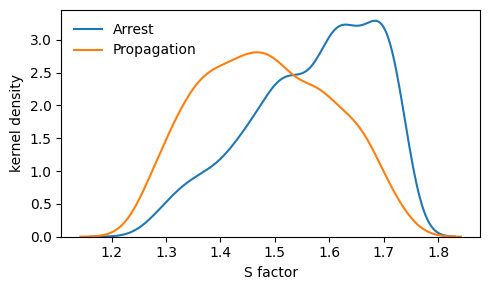

In [77]:
plt.figure(figsize=(5, 3))
sns.kdeplot(abs(df_train_all['sfactor'][df_train_all.label == 0]), shade= False)
sns.kdeplot(abs(df_train_all['sfactor'][df_train_all.label == 1]), shade= False)
plt.legend(['Arrest', 'Propagation'], 
           loc = 'upper left',
           framealpha = 0.0)

plt.xlabel('S factor')
plt.ylabel('kernel density')
plt.tight_layout()
plt.show()

The KDE shows the distribution of the S factor for two different outcomes: **Rupture arrest** (blue) and **Rupture propagation** (orange). The plot indicates that the S factor distributions differ between the two classes. For Rupture arrest, the distribution peaks at a higher S factor value (around **1.65**), while for Rupture propagation, the peak occurs at a lower S factor value (around **1.45**). The S factor could be a distinguishing feature for predicting whether a rupture will arrest or propagate.

### Scatter

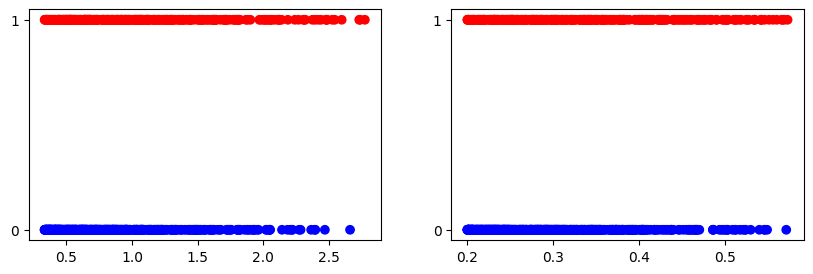

In [78]:
plt.figure(figsize = (10, 3))
plt.subplot(1,2, 1)
plt.scatter(df_train['mud']/df_train['sdrop'], df_train['label'], c = df_train['label'], cmap = 'bwr')
plt.yticks([0,1])
plt.grid(False)

plt.subplot(1,2, 2)
plt.scatter(df_train['mud'], df_train['label'], c = df_train['label'], cmap = 'bwr')
plt.yticks([0,1])
plt.grid(False)
plt.show()

The blue points correspond to **Class 0** (Rupture arrest), while the red points correspond to **Class 1** (Rupture propagate). Both plots show a clear separation between the two classes, with values clustering around distinct regions along the x-axis. The right-hand plot indicates a narrower range of x-values, suggesting that the second feature might have less variation compared to the first.

### Class Imbalanced

In [79]:
label_count = df_train_all.groupby('label', as_index = False).count()
class_name = ['Rupture arrest', 'Rupture propagate']
count = list(label_count['height'])
print('Rupture propagate : {}, \nRupture arrest: {}'.format(count[0], count[1]))
print('Total number of data: {}'.format(np.sum(count)))
print('Class ratio for rupture propagation: {}'.format(count[0]/count[1]))

Rupture propagate : 1041, 
Rupture arrest: 559
Total number of data: 1600
Class ratio for rupture propagation: 1.8622540250447228


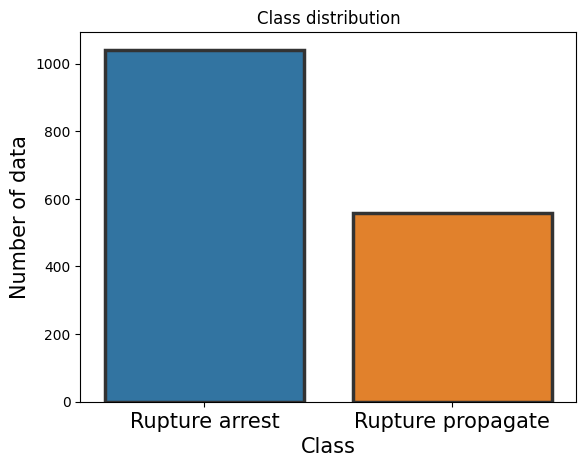

In [80]:
index = np.arange(len(class_name))
sns.barplot(x = class_name, y = count, linewidth = 2.5, errcolor = ".2", edgecolor = ".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

- We don't need to resample the data in this case because, while there is an imbalance between the two classes ("Rupture arrest" and "Rupture propagate"), the imbalance is not extremely severe. The minority class still has a significant number of samples, allowing the model to learn from both classes. 

- Additionally, techniques such as adjusting class weights during model training or using algorithms robust to class imbalance (e.g., Random Forest or XGBoost) can handle this level of imbalance without the need for resampling.

In [82]:
POS_CLASS_RATIO = count[0]/count[1]
aa = class_weight.compute_class_weight(class_weight='balanced', 
                                       classes=np.unique(ytrain.astype(int)), 
                                       y=ytrain.astype(int))
CLASS_WEIGHT = {0 : aa[0] , 1: aa[1]}

In [83]:
print(CLASS_WEIGHT)

{0: 0.7763975155279503, 1: 1.404494382022472}


## Neural Networks Technique

### Create and Train model

In [84]:
HIDDEN_LAYER_SIZE = 12
L2_REGULARIZER = 5
LEARNING_RATE = 0.0025
TRAINING_EPOCHS = 2000
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.30
CLASS_WEIGHT = CLASS_WEIGHT

We are constructing a neural network model using Keras, specifically a sequential model, which allows us to stack layers linearly. The first layer, defined as a dense layer, contains a specified number of hidden units (indicated by `HIDDEN_LAYER_SIZE`) and utilizes the ReLU activation function to introduce non-linearity into the model. The weights of this layer are initialized with a normal distribution centered at zero, while the biases are initialized to ones, ensuring that all neurons start with a positive bias.

We also apply L2 regularization to the weights to mitigate the risk of overfitting by penalizing large weights. Following the input layer, we compile the model with the Adam optimizer, known for its efficiency in training deep learning models, and use binary cross-entropy as the loss function, appropriate for binary classification tasks. Finally, we track the model's accuracy as a performance metric during training and evaluation, setting the stage for our model to learn from the data effectively.

In [120]:
model = Sequential()
model.add(Dense(HIDDEN_LAYER_SIZE, 
                activation='relu',
                kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1, seed=100),
                bias_initializer='Ones',
                input_shape=(9,),
                kernel_regularizer=regularizers.l2(L2_REGULARIZER),
                name='layer_1'))

adm_optz = optimizers.Adam(learning_rate=LEARNING_RATE)

model.add(Dense(1, activation="sigmoid", name='Output_layer'))
model.compile(optimizer=adm_optz, loss='binary_crossentropy', 
              metrics=['accuracy'])

We implement early stopping to enhance the training process by preventing overfitting. The `EarlyStopping` callback monitors the validation loss during training, and if it doesn't improve for a specified number of epochs (defined by `patience`), training will halt. This mechanism ensures that the model does not continue to fit to the noise in the training data beyond its optimal point.

We then fit the model to the training data (`xtrain_all` and `ytrain_all`) using the `fit` method. We specify a batch size (`BATCH_SIZE`) and the total number of epochs (`TRAINING_EPOCHS`) for training. Additionally, we apply class weights (`CLASS_WEIGHT`) to address any class imbalance in the dataset. 

The `validation_split` parameter indicates the proportion of the training data to be used for validation, allowing us to monitor the model's performance on unseen data during training. The training progress is set to be verbose level 0, which means minimal output will be shown in the console. By executing this code, we initiate the training process, during which the model learns to identify patterns in the data and optimize its performance for the task at hand.

In [121]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)
              
callback_list = [early_stopping]

history = model.fit(xtrain_all, ytrain_all, 
                    batch_size = BATCH_SIZE, 
                    epochs = TRAINING_EPOCHS,
                    class_weight = CLASS_WEIGHT,
                    callbacks = callback_list,
                    validation_split = VALIDATION_SPLIT, 
                    verbose = 0)

### Model evaluation

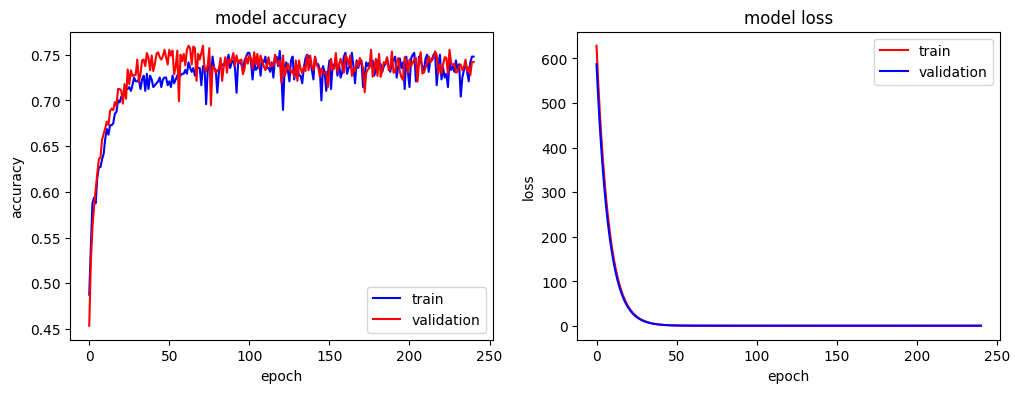

In [122]:
plt.figure(figsize= (12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], 'b-')
plt.plot(history.history['accuracy'], 'r-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], 'b-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

We observe from the model's performance over 250 epochs that both the training and validation accuracy steadily increase before stabilizing around 0.75. This trend indicates that the model is effectively learning from the data and generalizing well to unseen instances. 

In the loss plot, both training and validation loss rapidly decrease and stabilize after about 50 epochs. This suggests that the model has converged, meaning it has found an optimal set of weights that minimize the loss function. The close match between the training and validation curves further confirms the absence of significant overfitting. 

Overall, these results imply that the model is well-tuned and capable of making reliable predictions based on the features provided. This performance demonstrates the efficacy of the chosen architecture and training strategy, positioning us favorably for subsequent evaluations on test data.

### Train predictions

In [123]:
ypred_train = model.predict(xtrain_all)

50/50 [==============================] - 0s 828us/step


In [124]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score = roc_auc_score(ytrain_all, ypred_train)
fpr, tpr, thresholds = roc_curve(ytrain_all, ypred_train, pos_label = 1)

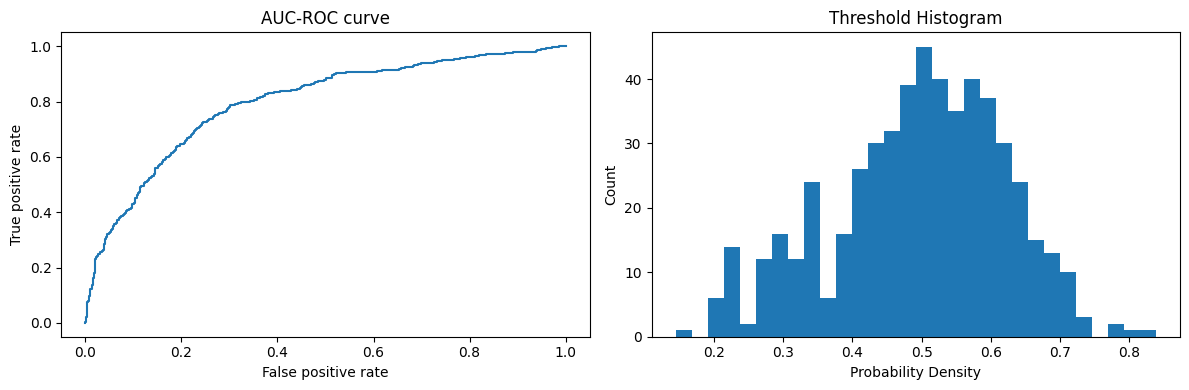

In [125]:
finite_thresholds = thresholds[np.isfinite(thresholds)]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr)
plt.title('AUC-ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.subplot(1, 2, 2)
plt.hist(finite_thresholds, bins=30)
plt.title('Threshold Histogram')
plt.xlabel('Probability Density')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

- We observe from the AUC-ROC curve that the model demonstrates reasonable performance, with the curve rising above the diagonal baseline. This indicates that the model can distinguish between the classes to a fair extent. A higher true positive rate (TPR) corresponds to a lower false positive rate (FPR), reflecting the model's ability to correctly identify positive instances while minimizing incorrect classifications.

- On the right, the Threshold Histogram shows the distribution of predicted probabilities, indicating that most predictions fall within the 0.3 to 0.6 range. This distribution suggests that the model is cautious in its predictions, leaning towards uncertain classifications rather than confident extremes. Such a distribution may highlight areas for potential optimization, as adjusting the decision threshold could enhance classification performance for specific applications. Overall, the combination of the AUC-ROC curve and the threshold histogram provides valuable insights into the model's predictive capabilities and areas for further refinement.

In [126]:
def prediction(xdata, ydata, threshold = 0.50):
    ypred_test_prob = model.predict(xdata)
    ypred_bin = [1.0 if val > threshold  else 0.0 for val in ypred_test_prob]
    print('Accuracy of the model: {}\n'.format(accuracy_score(ydata, ypred_bin)))
    print('Classification report: \n{}\n'.format(classification_report(ydata, ypred_bin)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ydata, ypred_bin)))

In [127]:
THRESHOLD = np.median(thresholds)
print(THRESHOLD)

0.51019436


In [128]:
prediction(xtrain_all, ytrain_all, threshold = THRESHOLD)

50/50 [==============================] - 0s 808us/step
Accuracy of the model: 0.744375

Classification report: 
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80      1041
         1.0       0.62      0.70      0.66       559

    accuracy                           0.74      1600
   macro avg       0.72      0.73      0.73      1600
weighted avg       0.75      0.74      0.75      1600


Confusion matrix: 
[[799 242]
 [167 392]]



We observe from the classification report that the model achieves an overall accuracy of **74.4%**. 

- For **Class 0 (Rupture arrest)**:
  - Precision: **0.83**
  - Recall: **0.77**
  - F1-score: **0.80**

- For **Class 1 (Rupture propagate)**:
  - Precision: **0.62**
  - Recall: **0.70**
  - F1-score: **0.66**

The confusion matrix indicates that **799 instances** of Class 0 and **392 instances** of Class 1 were correctly classified, with some misclassifications for both classes. 

It suggests that while the model is effective in identifying Rupture arrests, there is room for improvement in detecting Rupture propagation, as indicated by the lower precision and F1-score for this class. Enhancing the model's ability to distinguish between these classes could lead to better overall predictive performance.

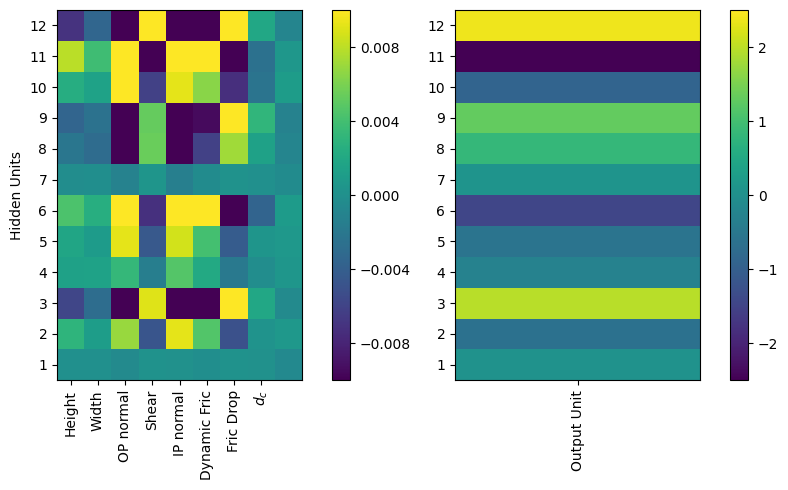

In [129]:
from matplotlib import ticker

weights = model.get_weights()

layer_1_weights = weights[0]    
layer_2_weights = weights[2]

plt.figure(figsize=(8, 5))
plt.subplot(1,2, 1)

aa = np.transpose(layer_1_weights)
plt.pcolormesh(aa, cmap = 'viridis', vmin = -0.010, vmax = 0.010)
labels = ['Height', 'Width', 'OP normal', 'Shear', 'IP normal', 'Dynamic Fric', 'Fric Drop', '$d_c$']

plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
plt.ylabel('Hidden Units')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

plt.subplot(1, 2, 2)
bb = np.reshape(layer_2_weights, (12, 1))
plt.pcolormesh(bb, cmap = 'viridis', vmin = -2.5, vmax = 2.5)
plt.xticks([0.5],['Output Unit'],rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

plt.tight_layout()
plt.show()


We observe from the heatmap that it visualizes the activations or weights between the **input features** and the **hidden units** on the left, and between the hidden units and the **output unit** on the right. Each color indicates the magnitude and direction (positive or negative) of the activations or weights. Input features such as **Height, OP Normal, Shear,** and **Fric Drop** interact differently with the hidden units, reflecting how the neural network learns from these inputs. The output unit shows a more uniform pattern from the hidden layers.

### Hypeparameters Tuning

In [132]:
import optuna

def create_model(trial):
    model = Sequential()
    
    hidden_layer_size = trial.suggest_int("hidden_layer_size", 8, 64)
    l2_regularizer = trial.suggest_loguniform("l2_regularizer", 1e-5, 1e-1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)

    model.add(Dense(hidden_layer_size, 
                    activation='relu',
                    kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1, seed=100),
                    bias_initializer='Ones',
                    input_shape=(9,),
                    kernel_regularizer=regularizers.l2(l2_regularizer),
                    name='layer_1'))

    adm_optz = optimizers.Adam(learning_rate=learning_rate)
    model.add(Dense(1, activation="sigmoid", name='Output_layer'))
    model.compile(optimizer=adm_optz, loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    callback_list = [early_stopping]
    
    history = model.fit(xtrain_all, ytrain_all, 
                        batch_size=32,
                        epochs=2000,
                        class_weight=CLASS_WEIGHT,
                        callbacks=callback_list,
                        validation_split=0.30, 
                        verbose=0)

    ypred_train = model.predict(xtrain_all)
    ypred_bin = (ypred_train > 0.5).astype(int)
    accuracy = accuracy_score(ytrain_all, ypred_bin)
    
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters: ", best_params)

best_accuracy = study.best_value
print("Best accuracy: ", best_accuracy)

[I 2024-09-21 22:22:58,165] A new study created in memory with name: no-name-f41cd4c0-de39-41ff-8724-beb4cdb244bd


50/50 [==============================] - 0s 681us/step


[I 2024-09-21 22:23:13,148] Trial 0 finished with value: 0.74375 and parameters: {'hidden_layer_size': 8, 'l2_regularizer': 0.07947505077223581, 'learning_rate': 0.0005831269916083156}. Best is trial 0 with value: 0.74375.


50/50 [==============================] - 0s 716us/step


[I 2024-09-21 22:23:15,415] Trial 1 finished with value: 0.743125 and parameters: {'hidden_layer_size': 21, 'l2_regularizer': 0.0015908605271967014, 'learning_rate': 0.08060327832020836}. Best is trial 0 with value: 0.74375.


50/50 [==============================] - 0s 995us/step


[I 2024-09-21 22:23:18,980] Trial 2 finished with value: 0.7725 and parameters: {'hidden_layer_size': 43, 'l2_regularizer': 0.0002574280146391696, 'learning_rate': 0.007083409561758963}. Best is trial 2 with value: 0.7725.


50/50 [==============================] - 0s 619us/step


[I 2024-09-21 22:25:17,796] Trial 3 finished with value: 0.763125 and parameters: {'hidden_layer_size': 18, 'l2_regularizer': 0.00182737581245411, 'learning_rate': 7.593856371739986e-05}. Best is trial 2 with value: 0.7725.


50/50 [==============================] - 0s 589us/step


[I 2024-09-21 22:25:23,583] Trial 4 finished with value: 0.813125 and parameters: {'hidden_layer_size': 48, 'l2_regularizer': 0.0002276233784384468, 'learning_rate': 0.007946631754181959}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 785us/step


[I 2024-09-21 22:25:26,124] Trial 5 finished with value: 0.728125 and parameters: {'hidden_layer_size': 50, 'l2_regularizer': 0.0003529750091807148, 'learning_rate': 0.09436402246739624}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 829us/step


[I 2024-09-21 22:25:28,603] Trial 6 finished with value: 0.783125 and parameters: {'hidden_layer_size': 47, 'l2_regularizer': 3.650593648022588e-05, 'learning_rate': 0.03660009274988161}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 923us/step


[I 2024-09-21 22:27:33,606] Trial 7 finished with value: 0.745625 and parameters: {'hidden_layer_size': 9, 'l2_regularizer': 0.045725559188937774, 'learning_rate': 3.127724340261868e-05}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 675us/step


[I 2024-09-21 22:27:54,031] Trial 8 finished with value: 0.76 and parameters: {'hidden_layer_size': 17, 'l2_regularizer': 0.00038033591589492943, 'learning_rate': 0.0004115759203015708}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 640us/step


[I 2024-09-21 22:27:56,500] Trial 9 finished with value: 0.755 and parameters: {'hidden_layer_size': 11, 'l2_regularizer': 0.00018510397839885986, 'learning_rate': 0.06092315900237357}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 831us/step


[I 2024-09-21 22:27:59,530] Trial 10 finished with value: 0.7575 and parameters: {'hidden_layer_size': 60, 'l2_regularizer': 1.1619778088668432e-05, 'learning_rate': 0.004100729550222678}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 819us/step


[I 2024-09-21 22:28:02,497] Trial 11 finished with value: 0.76 and parameters: {'hidden_layer_size': 31, 'l2_regularizer': 4.058230366531923e-05, 'learning_rate': 0.008825478131964045}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 551us/step


[I 2024-09-21 22:28:06,296] Trial 12 finished with value: 0.794375 and parameters: {'hidden_layer_size': 53, 'l2_regularizer': 4.118061164831391e-05, 'learning_rate': 0.015061298093492952}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 681us/step


[I 2024-09-21 22:28:12,831] Trial 13 finished with value: 0.76625 and parameters: {'hidden_layer_size': 61, 'l2_regularizer': 0.007390616278211041, 'learning_rate': 0.0018573475769184632}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 631us/step


[I 2024-09-21 22:28:15,631] Trial 14 finished with value: 0.760625 and parameters: {'hidden_layer_size': 54, 'l2_regularizer': 7.465915440713061e-05, 'learning_rate': 0.017370317039374597}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 1ms/step


[I 2024-09-21 22:28:22,104] Trial 15 finished with value: 0.786875 and parameters: {'hidden_layer_size': 36, 'l2_regularizer': 1.6589695417577025e-05, 'learning_rate': 0.002187802252934697}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 784us/step


[I 2024-09-21 22:28:26,969] Trial 16 finished with value: 0.804375 and parameters: {'hidden_layer_size': 40, 'l2_regularizer': 0.00010322191682509058, 'learning_rate': 0.017009197452692634}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 550us/step


[I 2024-09-21 22:29:03,377] Trial 17 finished with value: 0.749375 and parameters: {'hidden_layer_size': 30, 'l2_regularizer': 0.012236816436968095, 'learning_rate': 0.00018296254513042694}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 736us/step


[I 2024-09-21 22:30:35,711] Trial 18 finished with value: 0.744375 and parameters: {'hidden_layer_size': 42, 'l2_regularizer': 0.0001344614902432505, 'learning_rate': 1.1524836812411375e-05}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 758us/step


[I 2024-09-21 22:30:38,498] Trial 19 finished with value: 0.754375 and parameters: {'hidden_layer_size': 38, 'l2_regularizer': 0.0008089488325236029, 'learning_rate': 0.022861030635769615}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 686us/step


[I 2024-09-21 22:30:44,548] Trial 20 finished with value: 0.760625 and parameters: {'hidden_layer_size': 28, 'l2_regularizer': 0.004105898235524067, 'learning_rate': 0.0033750431174794818}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 691us/step


[I 2024-09-21 22:30:47,354] Trial 21 finished with value: 0.765 and parameters: {'hidden_layer_size': 55, 'l2_regularizer': 6.752200118132933e-05, 'learning_rate': 0.011013918312899409}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 733us/step


[I 2024-09-21 22:30:50,080] Trial 22 finished with value: 0.78125 and parameters: {'hidden_layer_size': 50, 'l2_regularizer': 2.593603911208239e-05, 'learning_rate': 0.032410514248184745}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 740us/step


[I 2024-09-21 22:30:59,812] Trial 23 finished with value: 0.789375 and parameters: {'hidden_layer_size': 56, 'l2_regularizer': 9.822398847848456e-05, 'learning_rate': 0.001380153084563647}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 646us/step


[I 2024-09-21 22:31:04,777] Trial 24 finished with value: 0.793125 and parameters: {'hidden_layer_size': 64, 'l2_regularizer': 0.0006185058434104826, 'learning_rate': 0.0062157199642198365}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 640us/step


[I 2024-09-21 22:31:08,064] Trial 25 finished with value: 0.801875 and parameters: {'hidden_layer_size': 45, 'l2_regularizer': 5.6503404626872966e-05, 'learning_rate': 0.01506813943571416}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 645us/step


[I 2024-09-21 22:31:10,651] Trial 26 finished with value: 0.770625 and parameters: {'hidden_layer_size': 43, 'l2_regularizer': 0.0001459120374244546, 'learning_rate': 0.03315490052824076}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 643us/step


[I 2024-09-21 22:31:32,774] Trial 27 finished with value: 0.78125 and parameters: {'hidden_layer_size': 36, 'l2_regularizer': 0.0005725152584501359, 'learning_rate': 0.0006960894875127677}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 738us/step


[I 2024-09-21 22:31:40,435] Trial 28 finished with value: 0.80375 and parameters: {'hidden_layer_size': 46, 'l2_regularizer': 0.0002372978418491907, 'learning_rate': 0.004234870095578002}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 743us/step


[I 2024-09-21 22:31:46,153] Trial 29 finished with value: 0.770625 and parameters: {'hidden_layer_size': 39, 'l2_regularizer': 0.0014330396194422832, 'learning_rate': 0.00465023316630256}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 736us/step


[I 2024-09-21 22:32:00,251] Trial 30 finished with value: 0.7925 and parameters: {'hidden_layer_size': 48, 'l2_regularizer': 0.0002978130086274769, 'learning_rate': 0.0007953359367308245}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 843us/step


[I 2024-09-21 22:32:02,726] Trial 31 finished with value: 0.794375 and parameters: {'hidden_layer_size': 45, 'l2_regularizer': 0.00010215272511152519, 'learning_rate': 0.01121795914090728}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 946us/step


[I 2024-09-21 22:32:06,362] Trial 32 finished with value: 0.780625 and parameters: {'hidden_layer_size': 33, 'l2_regularizer': 5.8532485161245266e-05, 'learning_rate': 0.003128948918683261}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 804us/step


[I 2024-09-21 22:32:09,720] Trial 33 finished with value: 0.7525 and parameters: {'hidden_layer_size': 41, 'l2_regularizer': 0.00020166469662009405, 'learning_rate': 0.052140051903750366}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 718us/step


[I 2024-09-21 22:32:13,714] Trial 34 finished with value: 0.770625 and parameters: {'hidden_layer_size': 25, 'l2_regularizer': 2.0307479906002704e-05, 'learning_rate': 0.0063526746047994475}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 751us/step


[I 2024-09-21 22:32:17,585] Trial 35 finished with value: 0.78125 and parameters: {'hidden_layer_size': 46, 'l2_regularizer': 0.0004493188505723254, 'learning_rate': 0.020085543794256255}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 777us/step


[I 2024-09-21 22:32:22,908] Trial 36 finished with value: 0.778125 and parameters: {'hidden_layer_size': 50, 'l2_regularizer': 0.0009707107275125803, 'learning_rate': 0.01106879743698012}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 777us/step


[I 2024-09-21 22:32:44,000] Trial 37 finished with value: 0.7875 and parameters: {'hidden_layer_size': 44, 'l2_regularizer': 0.00023410140032517079, 'learning_rate': 0.0004109466989802577}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 847us/step


[I 2024-09-21 22:32:55,472] Trial 38 finished with value: 0.77375 and parameters: {'hidden_layer_size': 39, 'l2_regularizer': 0.0022928317319608088, 'learning_rate': 0.0012605322104411877}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 945us/step


[I 2024-09-21 22:32:59,846] Trial 39 finished with value: 0.7375 and parameters: {'hidden_layer_size': 52, 'l2_regularizer': 0.08764146830620886, 'learning_rate': 0.09162658092162562}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 863us/step


[I 2024-09-21 22:33:06,308] Trial 40 finished with value: 0.805625 and parameters: {'hidden_layer_size': 58, 'l2_regularizer': 2.915487937775257e-05, 'learning_rate': 0.002311572000143542}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 573us/step


[I 2024-09-21 22:33:09,730] Trial 41 finished with value: 0.79875 and parameters: {'hidden_layer_size': 59, 'l2_regularizer': 3.272446397752817e-05, 'learning_rate': 0.005508663254653695}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 861us/step


[I 2024-09-21 22:33:13,505] Trial 42 finished with value: 0.77625 and parameters: {'hidden_layer_size': 50, 'l2_regularizer': 5.365511180973086e-05, 'learning_rate': 0.002020683344972231}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 852us/step


[I 2024-09-21 22:33:17,493] Trial 43 finished with value: 0.779375 and parameters: {'hidden_layer_size': 58, 'l2_regularizer': 1.027250020895937e-05, 'learning_rate': 0.0026536784702873434}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 682us/step


[I 2024-09-21 22:33:20,414] Trial 44 finished with value: 0.754375 and parameters: {'hidden_layer_size': 48, 'l2_regularizer': 0.00010773111636752433, 'learning_rate': 0.05086342355074999}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 866us/step


[I 2024-09-21 22:33:26,610] Trial 45 finished with value: 0.73875 and parameters: {'hidden_layer_size': 46, 'l2_regularizer': 0.00030839264464580174, 'learning_rate': 0.007100304676399228}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 1ms/step


[I 2024-09-21 22:33:29,117] Trial 46 finished with value: 0.769375 and parameters: {'hidden_layer_size': 34, 'l2_regularizer': 1.766155618917431e-05, 'learning_rate': 0.014539867999691626}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 819us/step


[I 2024-09-21 22:33:35,853] Trial 47 finished with value: 0.8075 and parameters: {'hidden_layer_size': 64, 'l2_regularizer': 0.0001688857447151105, 'learning_rate': 0.004048233011014822}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 704us/step


[I 2024-09-21 22:33:56,832] Trial 48 finished with value: 0.785 and parameters: {'hidden_layer_size': 64, 'l2_regularizer': 0.00016669751174146753, 'learning_rate': 0.000413025594213945}. Best is trial 4 with value: 0.813125.


50/50 [==============================] - 0s 1ms/step


[I 2024-09-21 22:34:09,751] Trial 49 finished with value: 0.799375 and parameters: {'hidden_layer_size': 62, 'l2_regularizer': 0.0004501896334698908, 'learning_rate': 0.0015751309836734516}. Best is trial 4 with value: 0.813125.


Best hyperparameters:  {'hidden_layer_size': 48, 'l2_regularizer': 0.0002276233784384468, 'learning_rate': 0.007946631754181959}
Best accuracy:  0.813125


### Fit the best model

In [150]:
best_model = Sequential()
best_model.add(Dense(best_params['hidden_layer_size'], 
                activation='relu',
                kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1, seed=100),
                bias_initializer='Ones',
                input_shape=(9,),
                kernel_regularizer=regularizers.l2(best_params['l2_regularizer']),
                name='layer_1'))

adm_optz = optimizers.Adam(learning_rate=best_params['learning_rate'])

best_model.add(Dense(1, activation="sigmoid", name='Output_layer'))
best_model.compile(optimizer=adm_optz, loss='binary_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)
              
callback_list = [early_stopping]

history = best_model.fit(xtrain_all, ytrain_all, 
                    batch_size = BATCH_SIZE, 
                    epochs = TRAINING_EPOCHS,
                    class_weight = CLASS_WEIGHT,
                    callbacks = callback_list,
                    validation_split = VALIDATION_SPLIT, 
                    verbose = 0)

### Test predictions

In [153]:
ypred_test_prob = best_model.predict(xtest)
ypred_test_bin = (ypred_test_prob > 0.5).astype(int)

print('Accuracy on test data: {}'.format(accuracy_score(ytest, ypred_test_bin)))
print('Classification report: \n{}'.format(classification_report(ytest, ypred_test_bin)))
print('Confusion matrix: \n{}'.format(confusion_matrix(ytest, ypred_test_bin)))

13/13 [==============================] - 0s 674us/step
Accuracy on test data: 0.835
Classification report: 
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       272
         1.0       0.76      0.71      0.73       128

    accuracy                           0.83       400
   macro avg       0.81      0.80      0.81       400
weighted avg       0.83      0.83      0.83       400

Confusion matrix: 
[[243  29]
 [ 37  91]]


We observe that the model achieved an accuracy of **83.5%** on the test data. For **Class 0 (Rupture arrest)**, the precision is 0.87, recall is 0.89, and the F1-score is 0.88, indicating strong performance. For **Class 1 (Rupture propagate)**, the precision is 0.76, recall is 0.71, and the F1-score is 0.73, showing decent but slightly weaker performance. The confusion matrix shows **243 correct predictions** for Class 0 and **91 correct predictions** for Class 1, with fewer misclassifications overall.

AUC-ROC: 0.8531
F1 Score: 0.7339


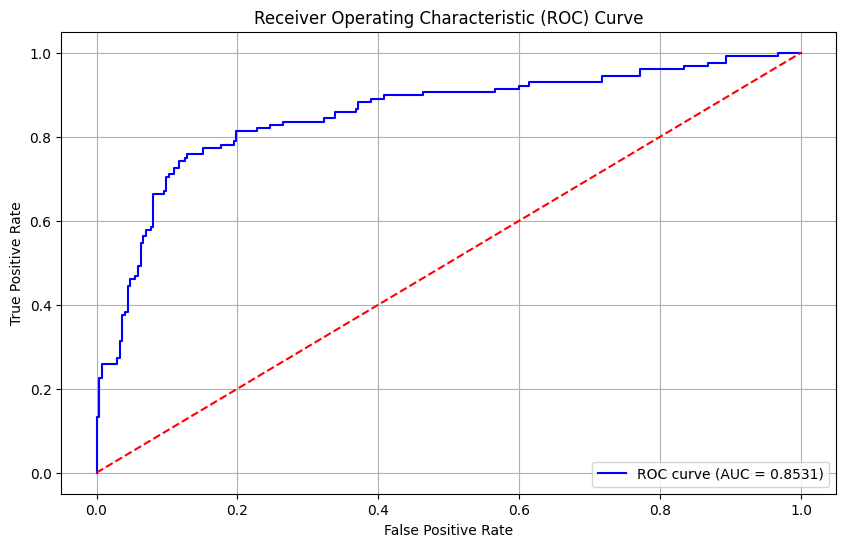

In [156]:
from sklearn.metrics import roc_auc_score, f1_score

roc_auc = roc_auc_score(ytest, ypred_test_prob)
print('AUC-ROC: {:.4f}'.format(roc_auc))

f1 = f1_score(ytest, ypred_test_bin)
print('F1 Score: {:.4f}'.format(f1))

fpr, tpr, thresholds = roc_curve(ytest, ypred_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()